<h1 style="color: white; background-color: green;">Sentiment Analysis for Amazon Reviews</h1>

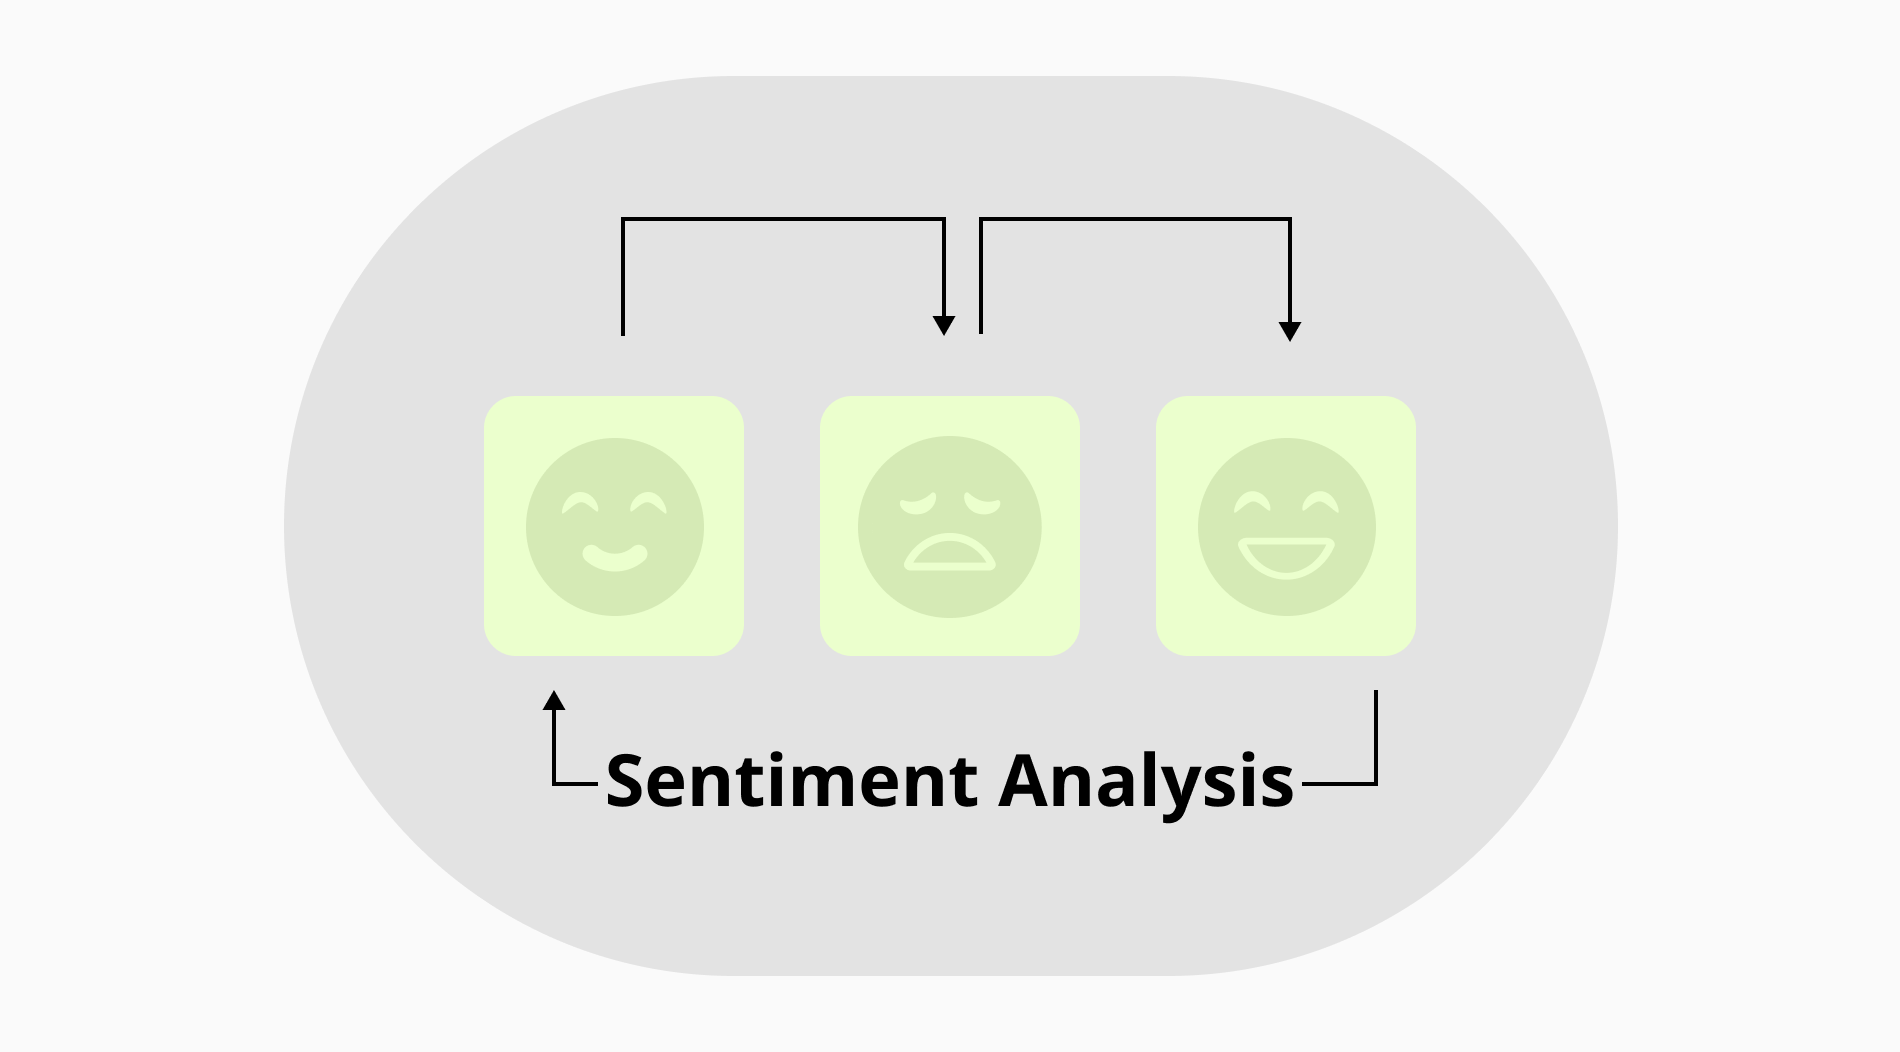

<h2 style="color: white; background-color: green;">Project Overview</h2>

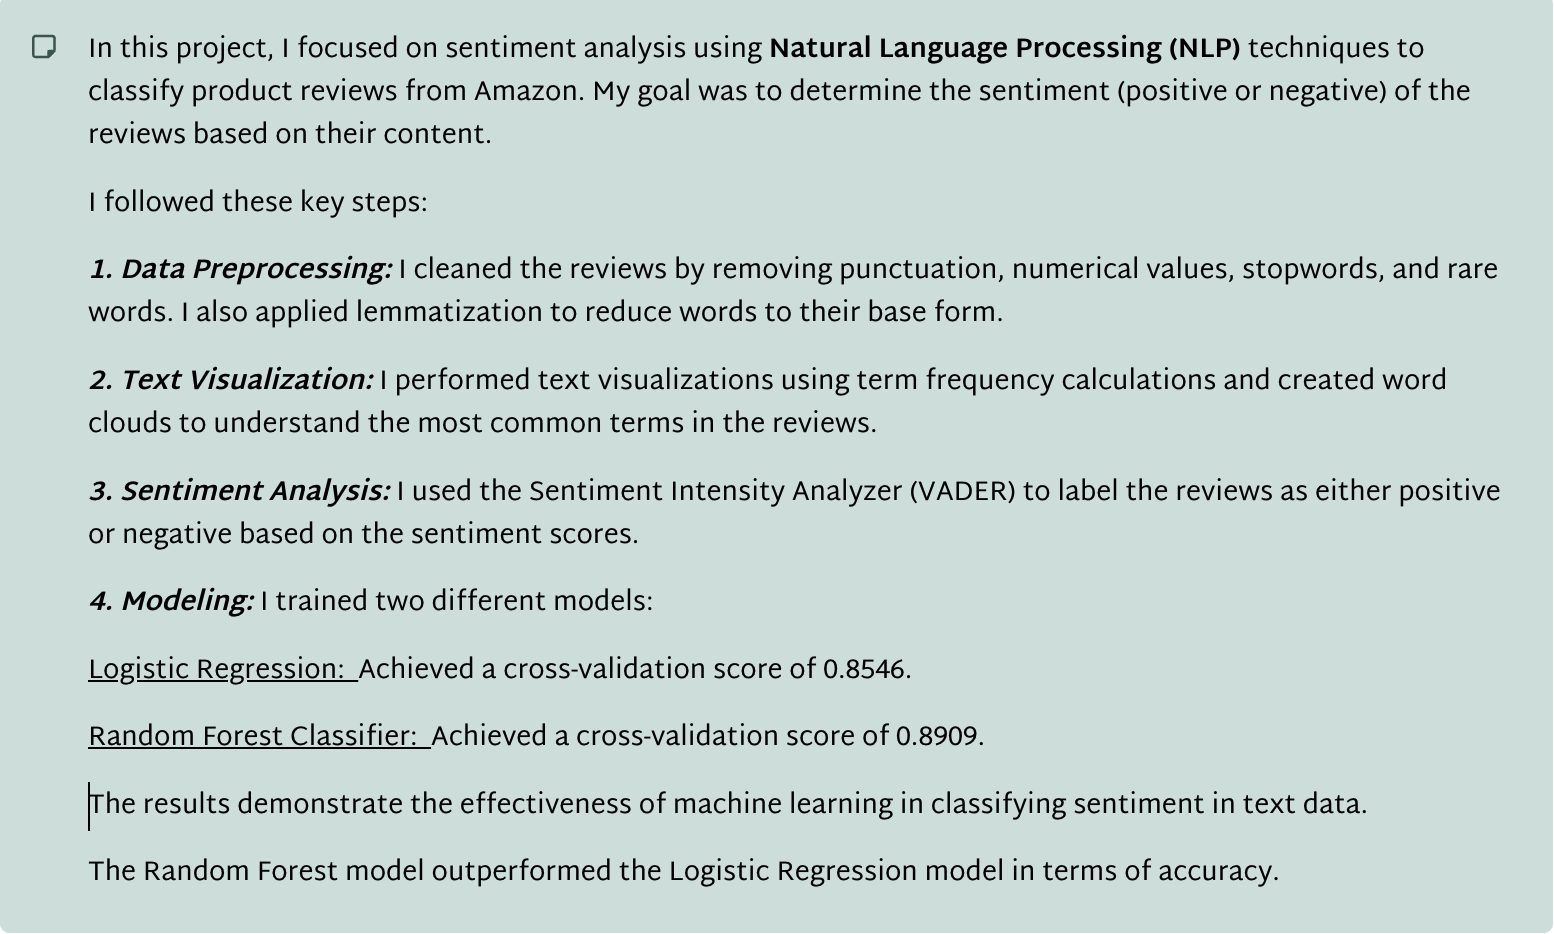

<h2 style="color: white; background-color: green;">Business Problem</h2>

Kozmos, which focuses on home textiles and daily clothing productions sold through Amazon, aims to increase its sales by analyzing customer reviews and improving its products based on received complaints. In line with this goal, sentiment analysis will be performed on the reviews, and the labeled data will be used to create a classification model.

<h2 style="color: white; background-color: green;">Dataset Story</h2>

The dataset consists of reviews made for a specific product group, including variables such as the review title, star rating, and the number of people who found the review helpful.

<h2 style="color: white; background-color: green;">Required Libraries</h2>

In [ ]:
!pip install nltk
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install pillow
!pip install textblob
!pip install wordcloud
!pip install scikit-surprise

In [ ]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from surprise.model_selection import train_test_split
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
import warnings
import nltk
import os

# Set the NLTK data path specifically for Kaggle
nltk_data_dir = "/kaggle/working/nltk_data"
os.makedirs(nltk_data_dir, exist_ok=True)
nltk.data.path.append(nltk_data_dir)

# Force install all required packages
nltk.download("stopwords", download_dir=nltk_data_dir, quiet=True)
nltk.download("punkt", download_dir=nltk_data_dir, quiet=True)
nltk.download("wordnet", download_dir=nltk_data_dir, quiet=True)
nltk.download("omw-1.4", download_dir=nltk_data_dir, quiet=True)

# Suppress warnings
filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning, module='nltk.twitter')

NOTE: WordNet Installation Issue Solution

In the Kaggle environment, there might be issues accessing NLTK's WordNet database. 
The following code block is used to solve this problem:

1. WordNet is manually downloaded from the GitHub NLTK repository
2. The downloaded ZIP file is extracted to the correct location
3. The new WordNet directory is introduced to NLTK

If you're getting this error:
Resource 'corpora/wordnet' not found. Please use the NLTK Downloader to obtain the resource.

The code block below will solve the issue.

In [ ]:
import nltk
import os
import urllib.request
import zipfile
from pathlib import Path

# Set the NLTK data directory for Kaggle
nltk_data_dir = Path("/kaggle/working/nltk_data")
corpora_dir = nltk_data_dir / "corpora"

# Create the necessary directories
corpora_dir.mkdir(parents=True, exist_ok=True)

# Manually download WordNet
wordnet_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/wordnet.zip"
wordnet_zip = corpora_dir / "wordnet.zip"

print("Downloading WordNet...")
try:
    urllib.request.urlretrieve(wordnet_url, wordnet_zip)
    print("Download complete.")
    
    # Unzip the ZIP file
    with zipfile.ZipFile(wordnet_zip, 'r') as zip_ref:
        zip_ref.extractall(corpora_dir)
    print("The ZIP file is extracted.")
    
    # Delete the ZIP file
    wordnet_zip.unlink()
    print("The ZIP file is deleted.")
    
except Exception as e:
    print(f"Download or open error: {str(e)}")

# Add the path to NLTK
nltk.data.path.insert(0, str(nltk_data_dir))

# Check it
print("\nFile check:")
wordnet_dir = corpora_dir / "wordnet"
print(f"Is the WordNet directory present: {wordnet_dir.exists()}")
if wordnet_dir.exists():
    print("WordNet files:")
    for file in wordnet_dir.glob("*"):
        print(f"- {file.name}")

# Test it
try:
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    test_word = "running"
    result = lemmatizer.lemmatize(test_word, pos="v")
    print(f"\nThe lemmatization test is successful: '{test_word}' -> '{result}'")
except Exception as e:
    print(f"\nLemmatization error: {str(e)}")

<h2 style="color: white; background-color: green;">Text Preprocessing</h2>

In [ ]:
df = pd.read_csv("/kaggle/input/kozmos/kozmos.csv")
df.head()

In [ ]:
df.shape

In [ ]:
df.info()

<h3 style="color: white; background-color: green;">Normalizing Case Folding</h3>

In [ ]:
df['Review'] = df['Review'].str.lower()
df['Review']

<h3 style="color: white; background-color: green;">Removing Punctuation</h3>

In [ ]:
df['Review'] = df['Review'].str.replace('[^\w\s]', '', regex=True)
df['Review']

<h3 style="color: white; background-color: green;">Removing Numerical Values</h3>

In [ ]:
df['Review'] = df['Review'] .str.replace('\d', '', regex=True)
df['Review']

<h3 style="color: white; background-color: green;">Removing Stopwords</h3>

In [ ]:
sw = stopwords.words('english')

In [ ]:
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df["Review"]

<h3 style="color: white; background-color: green;">Removing Rarewords</h3>

In [ ]:
drops = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
drops

In [ ]:
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))
df['Review']

<h3 style="color: white; background-color: green;">Lemmatization</h3>

In [ ]:
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['Review']

<h2 style="color: white; background-color: green;">Text Visualization</h2>

<h3 style="color: white; background-color: green;">Calculation of Term Frequencies</h3>

In [ ]:
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf.sort_values("tf", ascending=False)

<h3 style="color: white; background-color: green;">Barplot</h3>

In [ ]:
tf[tf["tf"] > 500].plot.bar(x="words", y="tf", color="green", figsize=(10,5))
plt.show()

<h3 style="color: white; background-color: green;">Wordcloud</h3>

In [ ]:
text = " ".join(i for i in df.Review)

wordcloud = WordCloud(max_font_size=70,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h2 style="color: white; background-color: green;">Sentiment Analysis</h2>

In [ ]:
df["Review"].head()

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

In [ ]:
df["Polarity_Score"] = df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])
df["Polarity_Score"]

In [ ]:
df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df["Sentiment_Label"]

In [ ]:
df["Sentiment_Label"].value_counts()

In [ ]:
df.groupby("Sentiment_Label")["Star"].mean()

By labeling comments with Sentiment Intensity Analyzer, the dependent variable for the comment classification machine learning model was created.


<h2 style="color: white; background-color: green;">Machine Learning Preparation</h2>

In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                   df["Sentiment_Label"],
                                                   random_state=42)

<h3 style="color: white; background-color: green;">Creating a TF-IDF Vectorizer</h3>

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()

<h3 style="color: white; background-color: green;">Vectorizing the Training Data</h3>

In [ ]:
X_train_tfidf = tfidf.fit_transform(train_x)
X_test_tfidf = tfidf.transform(test_x)

<h2 style="color: white; background-color: green;">Modeling (Logistic Regression)</h2>

<h3 style="color: white; background-color: green;">Model Training</h3>

In [ ]:
log_model = LogisticRegression()
log_model.fit(X_train_tfidf, train_y)

<h3 style="color: white; background-color: green;">Model Performance</h3>

In [ ]:
y_pred = log_model.predict(X_test_tfidf)
print("Model Performance:")
print(classification_report(y_pred, test_y))

In [ ]:
log_score = cross_val_score(log_model, X_test_tfidf, test_y, cv=5).mean()
log_score

<h3 style="color: #00FF00;">Selecting a random comment and making a prediction</h3>

In [ ]:
random_review = df["Review"].sample(1).iloc[0]
new_review = tfidf.transform([random_review])
pred = log_model.predict(new_review)

print(f"Review: {random_review} \nPrediction: {pred}")

<h2 style="color: white; background-color: green;">Modeling (Random Forest)</h2>

In [ ]:
rf_model = RandomForestClassifier().fit(X_train_tfidf, train_y)
rf_score = cross_val_score(rf_model, X_test_tfidf, test_y, cv=5, n_jobs=-1).mean()
rf_score

<h2 style="color: white; background-color: green;">Model Performance Comparison and Evaluation</h2>

In [ ]:
print(f"Logistic Regression Score: {log_score:.4f}")
print(f"Random Forest Score: {rf_score:.4f}")

if log_score > rf_score:
    print("Logistic Regression performed better.")
elif log_score < rf_score:
    print("Random Forest performed better.")
else:
    print("Both models performed equally well.")

In [ ]:
diff = abs(log_score - rf_score)
percentage_diff = (diff / max(log_score, rf_score)) * 100
print(f"Performance difference: {percentage_diff:.2f}%")